In [ ]:
#IMPORT LIABARIES
import pandas as pd
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os
from sklearn.decomposition import PCA



c:\Users\MK699GC\OneDrive - EY\Documents\EMAS\Case 6


In [ ]:
#CHECK PATH, SET TO CORRECT PATH:
print(os.getcwd())
os.chdir("C:/Users/MK699GC/OneDrive - EY/Documents/EMAS\Case 6/interest_rates/data")

In [ ]:
#LOADING IN DATA:
def load_term_structures(pattern, prefix):
    """
    Laad CSV bestanden volgens het glob pattern,
    voeg prefix toe aan kolomnamen (bijv. 'daily' of 'monthly')
    """
    files = glob.glob(pattern)
    dataframes = []

    print(f"Loading files with pattern '{pattern}'")
    for file in files:
        match = re.search(r'R(\d{2})XX', file)
        if not match:
            print(f"Term length not found in filename: {file}, skipping")
            continue
        term_length = match.group(1)

        df = pd.read_csv(file, skiprows=9, header=None, usecols=[0, 1])
        df.columns = ['years', f'{prefix}_data_term_{term_length}']
        dataframes.append(df)

    if not dataframes:
        print(f"No files loaded for pattern {pattern}")
        return None

    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on='years', how='outer')

    merged_df = merged_df.sort_values(by='years').reset_index(drop=True)

    # Vervang '.' door NaN en converteer naar numeriek
    term_cols = [col for col in merged_df.columns if col.startswith(f'{prefix}_data_term_')]
    for col in term_cols:
        merged_df[col] = merged_df[col].replace('.', np.nan)
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

    return merged_df

# Daily data laden
daily_df = load_term_structures('daily-term-structure-spot-interest-rate-R*XX.csv', 'daily')

# Monthly data laden
monthly_df = load_term_structures('monthly-term-structure-spot-interest-rate-R*XX.csv', 'monthly')

print("Daily data sample:")
print(daily_df.head() if daily_df is not None else "No daily data loaded")

print("\nMonthly data sample:")
print(monthly_df.head() if monthly_df is not None else "No monthly data loaded")

Loading files with pattern 'daily-term-structure-spot-interest-rate-R*XX.csv'
Loading files with pattern 'monthly-term-structure-spot-interest-rate-R*XX.csv'
Daily data sample:
        years  daily_data_term_01  daily_data_term_02  daily_data_term_03  \
0  1997-08-01                 NaN                 NaN                 NaN   
1  1997-08-02                 NaN                 NaN                 NaN   
2  1997-08-03                 NaN                 NaN                 NaN   
3  1997-08-04                 NaN                 NaN                 NaN   
4  1997-08-05                 NaN                 NaN                 NaN   

   daily_data_term_04  daily_data_term_05  daily_data_term_06  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN              

C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\4172256936.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_df['years'] = pd.to_datetime(monthly_df['years'], errors='coerce')


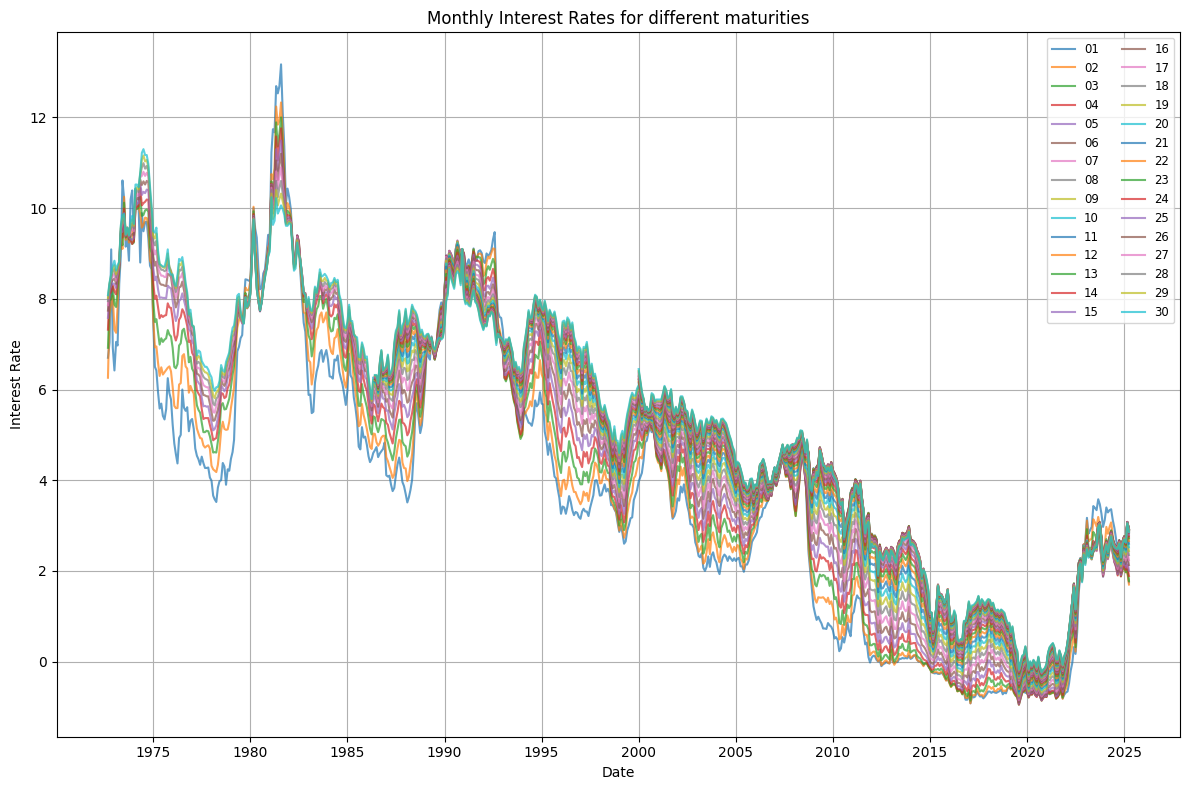

In [3]:
#PLOT MONTHLY TERM STRUCTURE

monthly_df['years'] = pd.to_datetime(monthly_df['years'], errors='coerce')

plt.figure(figsize=(12, 8))

monthly_cols = sorted([col for col in monthly_df.columns if col.startswith('monthly_data_term_')])

for col in monthly_cols:
    label = col.replace('monthly_data_term_', '')  # Alleen het jaarnummer
    plt.plot(monthly_df['years'], monthly_df[col], label=label, alpha=0.7)

plt.title('Monthly Interest Rates for different maturities')
plt.xlabel('Date')
plt.ylabel('Interest Rate')

# Stel de x-as formatter en locator in voor datums
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  # elke 5 jaar een tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


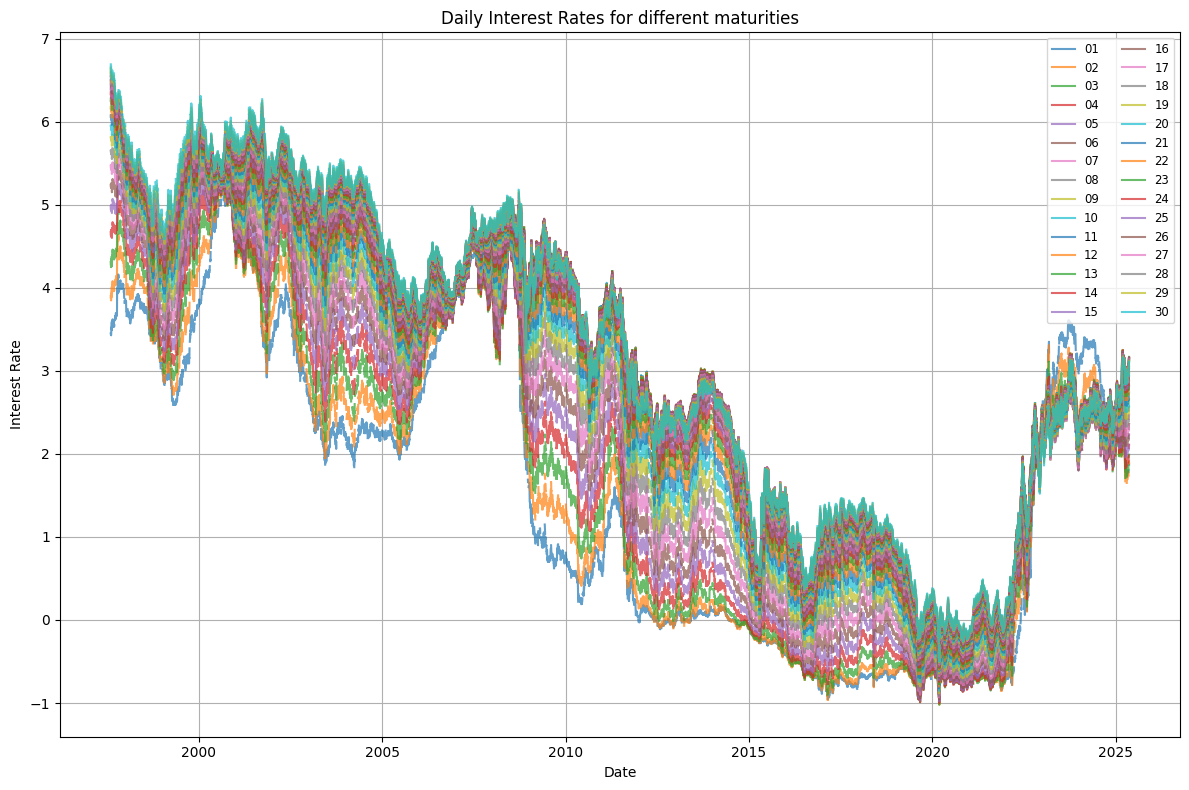

In [4]:
# PLOT DAILY TERM STRUCTURE

daily_df['years'] = pd.to_datetime(daily_df['years'], errors='coerce')

plt.figure(figsize=(12, 8))

daily_cols = sorted([col for col in daily_df.columns if col.startswith('daily_data_term_')])

for col in daily_cols:
    label = col.replace('daily_data_term_', '')  # Alleen het jaarnummer
    plt.plot(daily_df['years'], daily_df[col], label=label, alpha=0.7)

plt.title('Daily Interest Rates for different maturities')
plt.xlabel('Date')
plt.ylabel('Interest Rate')

# Stel de x-as formatter en locator in voor datums
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  # elke 5 jaar een tick
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# DESCRIPTIVE STATISTICS
def descriptive_stats(df):
    import re
    import numpy as np
    import pandas as pd

    # Sluit kolommen uit die met 'year' of 'Year' beginnen
    to_drop = [col for col in df.columns if col.lower().startswith('year')]
    data_cols = df.columns.drop(to_drop)

    # Statistieken opvragen
    stats = df[data_cols].describe().T
    stats['missing_pct'] = df[data_cols].isna().mean() * 100

    # Startjaar bepalen
    start_years = {}
    year_col = next((c for c in df.columns if c.lower().startswith('year')), None)
    for col in data_cols:
        first_valid_idx = df[col].first_valid_index()
        if first_valid_idx is not None and year_col is not None:
            start_year = df.loc[first_valid_idx, year_col].year
        else:
            start_year = np.nan
        start_years[col] = start_year

    stats['Start Year'] = pd.Series(start_years)

    # Zet kolomnamen (zoals 'daily_01') in een kolom om maturity te extraheren
    stats['Column Name'] = stats.index

    # Extract maturity-nummer uit kolomnaam
    stats['Maturity'] = stats['Column Name'].str.extract(r'(\d+)$')[0].astype(int)

    # Hernoemen van kolommen
    stats = stats.rename(columns={
        'count': 'Count',
        'mean': 'Mean',
        '50%': 'Median',
        'std': 'Std',
        'min': 'Min',
        'max': 'Max',
        'missing_pct': 'Missing %'
    })

    # Kolommen ordenen
    stats = stats[['Maturity', 'Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Missing %', 'Start Year']]

    # Sorteren op Maturity
    stats = stats.sort_values('Maturity').reset_index(drop=True)

    # ✅ Index starten bij 1
    stats.index = stats.index + 1

    # Afronden
    stats = stats.round(2)

    return stats


def style_stats_table_clean(stats_df, title):
    styles = [
        {'selector': 'caption',
         'props': [('caption-side', 'top'), 
                   ('text-align', 'center'),
                   ('font-size', '18px'), 
                   ('font-weight', 'bold'),
                   ('padding', '10px 0')]},
        {'selector': 'th',
         'props': [('background-color', '#e1e1e1'), 
                   ('color', '#333'),
                   ('text-align', 'center'),
                   ('font-weight', '600'),
                   ('border-bottom', '1px solid #ccc'),
                   ('padding', '6px 8px')]},
        {'selector': 'td',
         'props': [('text-align', 'right'),
                   ('padding', '6px 8px'),
                   ('border-bottom', '1px solid #eee')]},
        {'selector': 'tbody tr:hover',
         'props': [('background-color', '#f5f5f5')]},
    ]
    
    return (stats_df.style
            .set_caption(title)
            .set_table_styles(styles)
            .format({
                'Count': '{:,.0f}',
                'Mean': '{:.2f}',
                'Median': '{:.2f}',
                'Std': '{:.2f}',
                'Min': '{:.2f}',
                'Max': '{:.2f}',
                'Missing %': '{:.1f}%',
                'Start Year': '{:.0f}'
            }))

# Gebruik:
daily_stats = descriptive_stats(daily_df)
monthly_stats = descriptive_stats(monthly_df)

display(style_stats_table_clean(daily_stats, "Descriptive Statistics Daily Data"))
display(style_stats_table_clean(monthly_stats, "Descriptive Statistics Monthly Data"))

daily_stats.to_excel('daily_stats.xlsx')
monthly_stats.to_excel('monthly_stats.xlsx')

,Maturity,Count,Mean,Median,Std,Min,Max,Missing %,Start Year
1,1,"7,048",1.56,1.81,1.84,-0.97,5.23,30.6%,1997
2,2,"7,048",1.66,1.89,1.86,-1.02,5.32,30.6%,1997
3,3,"7,048",1.78,1.99,1.89,-1.02,5.33,30.6%,1997
4,4,"7,048",1.91,2.17,1.90,-1.00,5.35,30.6%,1997
5,5,"7,048",2.05,2.32,1.91,-0.98,5.42,30.6%,1997
6,6,"7,048",2.18,2.43,1.91,-0.95,5.48,30.6%,1997
7,7,"7,048",2.31,2.48,1.91,-0.93,5.61,30.6%,1997
8,8,"7,048",2.43,2.55,1.91,-0.91,5.73,30.6%,1997
9,9,"7,048",2.53,2.66,1.90,-0.88,5.84,30.6%,1997
10,10,"7,048",2.63,2.76,1.90,-0.85,5.97,30.6%,1997


,Maturity,Count,Mean,Median,Std,Min,Max,Missing %,Start Year
1,1,632,3.91,3.80,3.22,-0.92,13.17,0.0%,1972
2,2,632,4.09,4.08,3.21,-0.92,12.33,0.0%,1972
3,3,632,4.27,4.38,3.21,-0.95,12.00,0.0%,1972
4,4,632,4.44,4.62,3.21,-0.95,11.76,0.0%,1972
5,5,632,4.58,4.81,3.19,-0.93,11.49,0.0%,1972
6,6,632,4.70,5.01,3.17,-0.90,11.20,0.0%,1972
7,7,632,4.81,5.14,3.14,-0.85,10.90,0.0%,1972
8,8,632,4.91,5.23,3.11,-0.80,10.99,0.0%,1972
9,9,632,4.99,5.28,3.07,-0.76,11.16,0.0%,1972
10,10,632,5.06,5.33,3.05,-0.71,11.30,0.0%,1972


C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\4235130637.py:103: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  daily_stats.to_excel('daily_stats.xlsx')
C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\4235130637.py:104: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  monthly_stats.to_excel('monthly_stats.xlsx')


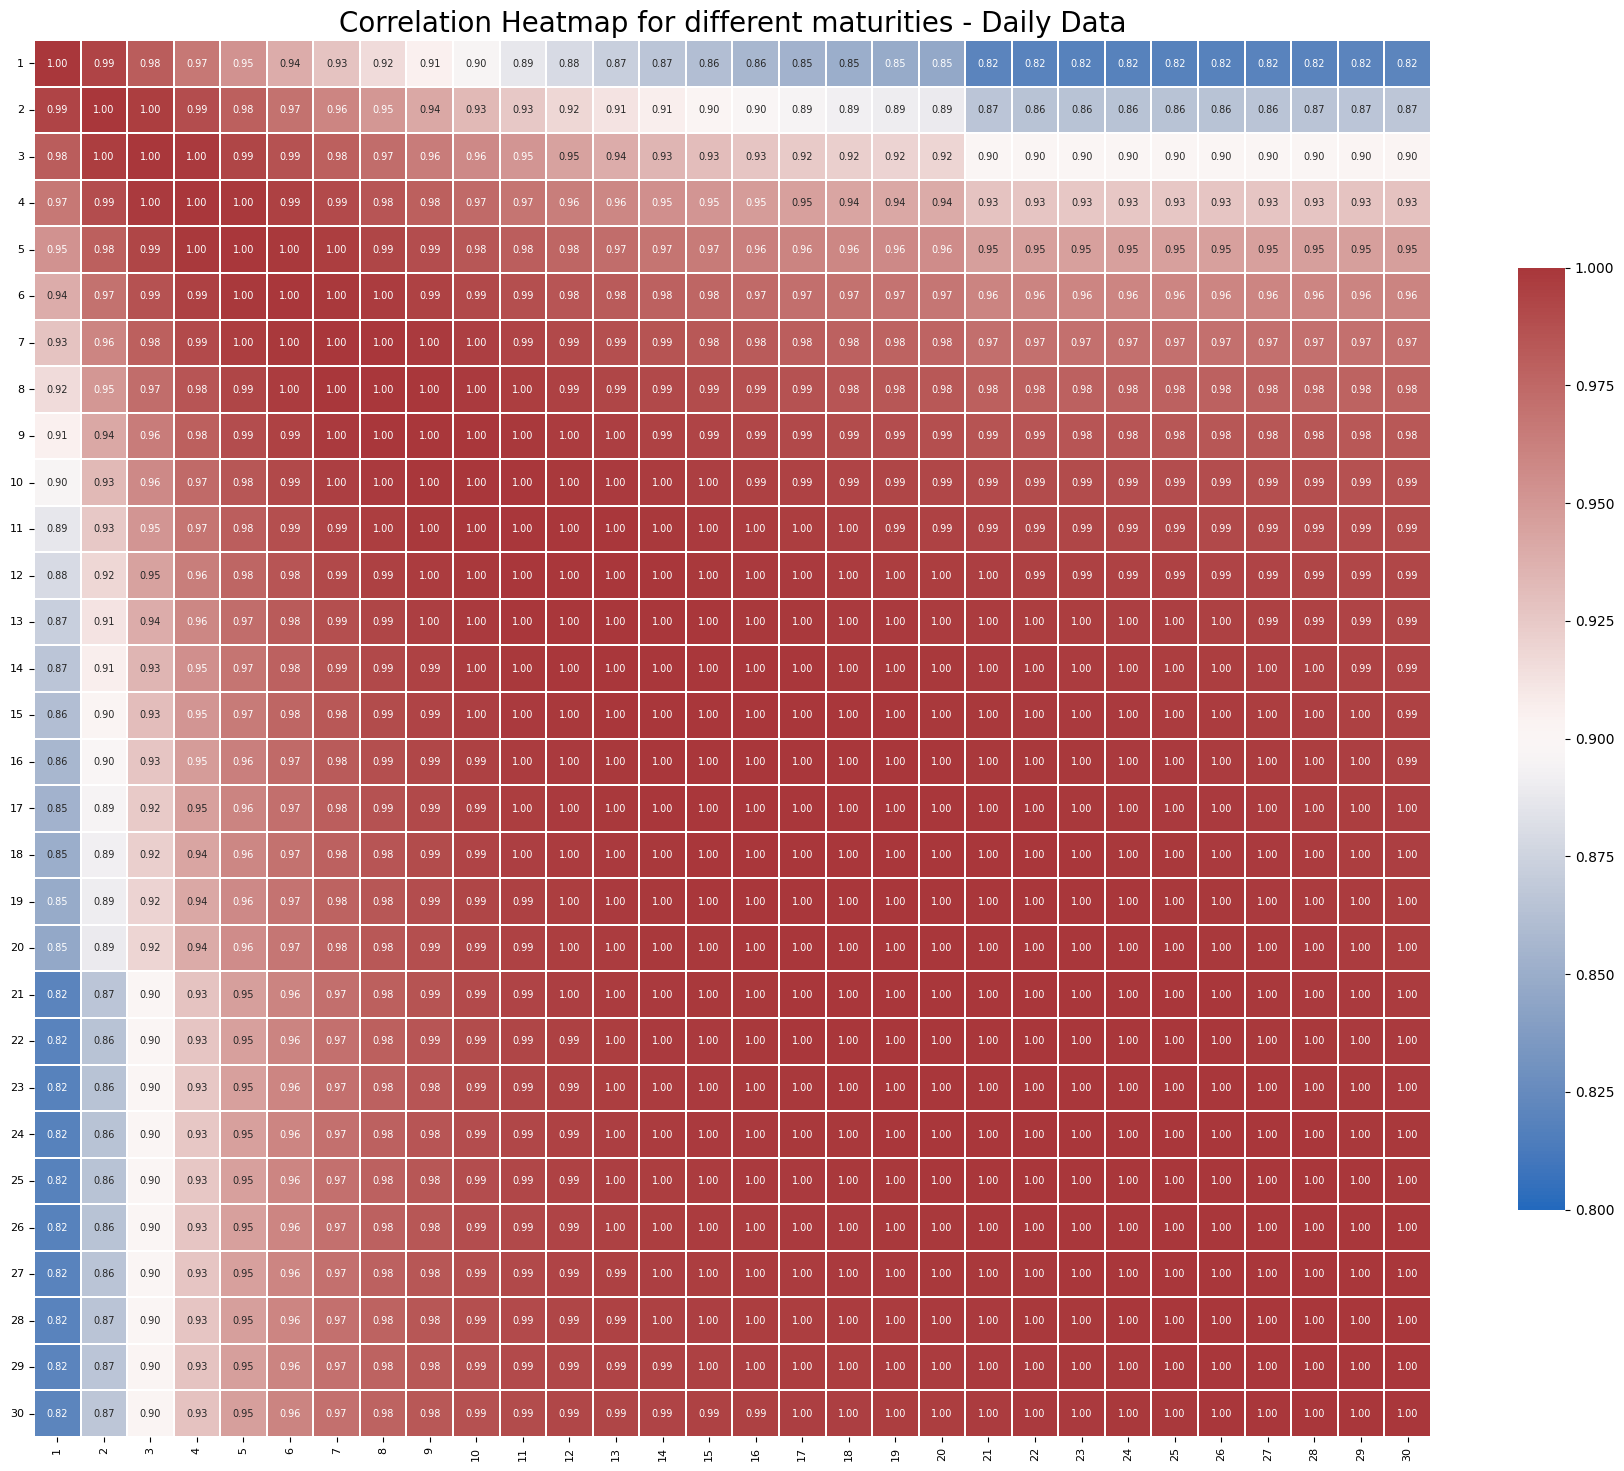

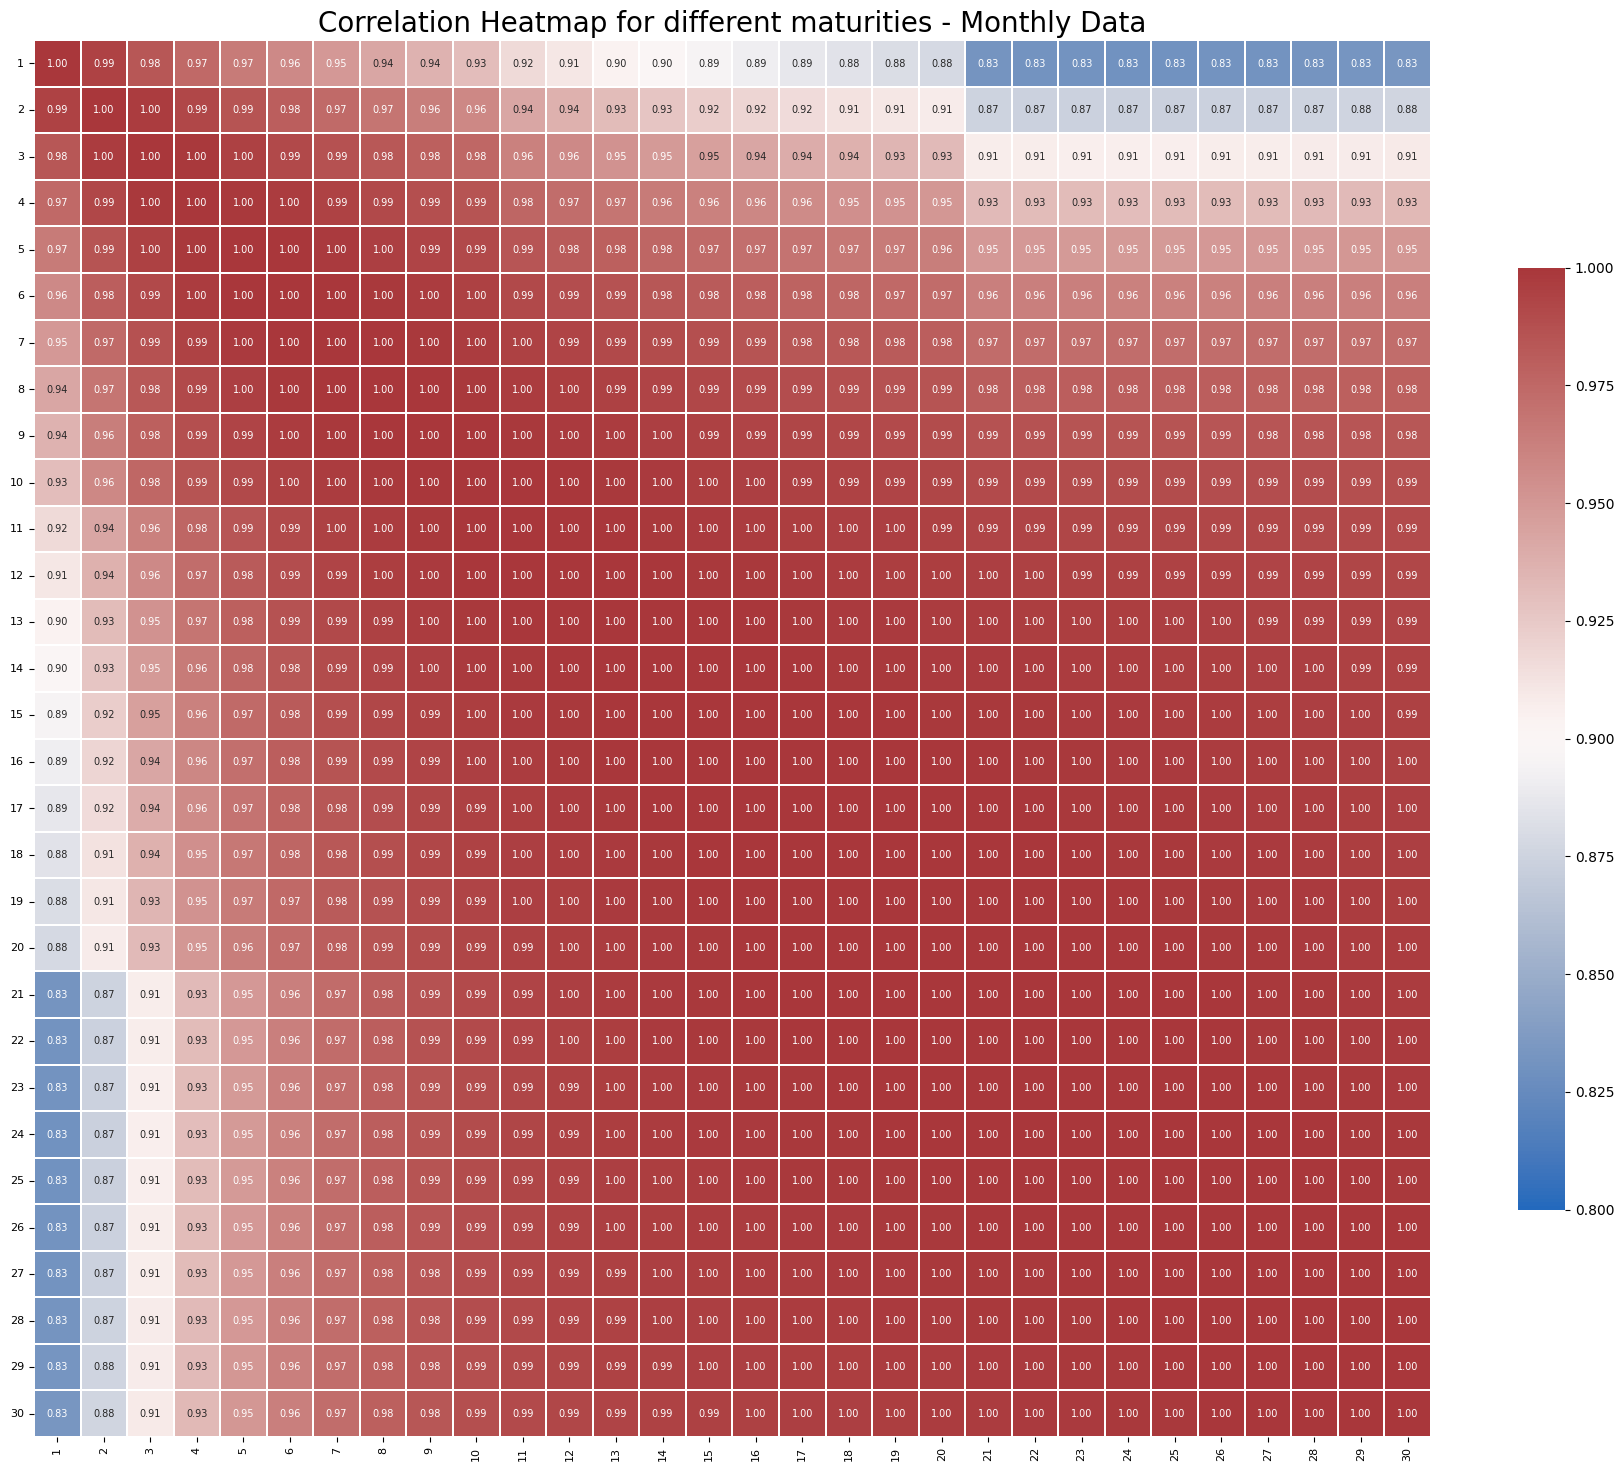

Correlation matrix - Daily Data:
                    daily_data_term_01  daily_data_term_02  \
daily_data_term_01               1.000               0.993   
daily_data_term_02               0.993               1.000   
daily_data_term_03               0.981               0.996   
daily_data_term_04               0.967               0.989   
daily_data_term_05               0.953               0.979   
daily_data_term_06               0.940               0.970   
daily_data_term_07               0.927               0.960   
daily_data_term_08               0.916               0.950   
daily_data_term_09               0.905               0.941   
daily_data_term_10               0.896               0.933   
daily_data_term_11               0.887               0.925   
daily_data_term_12               0.879               0.918   
daily_data_term_13               0.872               0.912   
daily_data_term_14               0.866               0.906   
daily_data_term_15               0.86

In [ ]:
#CORRELATION MATRIX
def plot_correlation_heatmap_annotated(df, title):
    term_cols = sorted([col for col in df.columns if 'data_term_' in col])
    corr = df[term_cols].corr()

    plt.figure(figsize=(18,16))
    ax = sns.heatmap(
        corr,
        cmap='vlag',
        center=0.9,
        vmin=0.8,
        vmax=1.0,
        square=True,
        annot=True,
        fmt=".2f",
        annot_kws={"size":7},
        linewidths=0.3,
        cbar_kws={"shrink": 0.6}
    )
    plt.title(title, fontsize=20)

    # Vervang de xticks en yticks labels door alleen het nummer (bijv. '1' in plaats van 'daily_data_term_01')
    new_labels = [col.split('_')[-1] for col in term_cols]  # pakt '01', '02', etc.
    new_labels = [str(int(label)) for label in new_labels]  # converteert '01' -> '1' als string

    ax.set_xticklabels(new_labels, rotation=90, fontsize=8)
    ax.set_yticklabels(new_labels, fontsize=8)
    
    plt.tight_layout()
    plt.show()

    return corr

# Plot en sla de correlatiematrices op
daily_corr = plot_correlation_heatmap_annotated(daily_df, 'Correlation Heatmap for different maturities - Daily Data')
monthly_corr = plot_correlation_heatmap_annotated(monthly_df, 'Correlation Heatmap for different maturities - Monthly Data')

# Toon de correlatiematrices als tabel
print("Correlation matrix - Daily Data:")
print(daily_corr.round(3))

print("\nCorrelation matrix - Monthly Data:")
print(monthly_corr.round(3))

In [7]:
#STATIONARITY TEST


def adf_test_all_to_table(df, freq_label):
    results = []
    terms = [col for col in df.columns if col.startswith(f'{freq_label}_data_term_')]
    
    for term in sorted(terms):
        series = df[term].dropna()
        result = adfuller(series)
        p_value = result[1]
        is_stationary = 'Yes' if p_value < 0.05 else 'No'

        maturity_num = int(re.search(r'_(\d+)$', term).group(1))

        results.append({
            'Maturity': maturity_num,
            'ADF Statistic': round(result[0], 4),
            'p-value': round(p_value, 4),
            'Stationary': is_stationary
        })
    
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('Maturity').reset_index(drop=True)
    return df_results

# Maak de tabellen
daily_adf_results = adf_test_all_to_table(daily_df, 'daily')
monthly_adf_results = adf_test_all_to_table(monthly_df, 'monthly')

# Exporteer naar Excel (in dezelfde map waar je script draait)
daily_adf_results.to_excel('daily_adf_results.xlsx', index=False)
monthly_adf_results.to_excel('monthly_adf_results.xlsx', index=False)

print("Export complete! Je vindt de bestanden 'daily_adf_results.xlsx' en 'monthly_adf_results.xlsx' in je werkmap.")

Export complete! Je vindt de bestanden 'daily_adf_results.xlsx' en 'monthly_adf_results.xlsx' in je werkmap.


C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\1597246384.py:32: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  daily_adf_results.to_excel('daily_adf_results.xlsx', index=False)
C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\1597246384.py:33: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  monthly_adf_results.to_excel('monthly_adf_results.xlsx', index=False)


C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\3234682566.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_year_daily = daily_df.groupby('year').apply(lambda x: x.isna().mean() * 100)
C:\Users\MK699GC\AppData\Local\Temp\ipykernel_40340\3234682566.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_year_monthly = monthly_df.groupby('year').apply(lambda x: x.isna().mean() * 100


Average missing % per year - Daily:
year
1997.0    52.900327
1998.0    50.770548
1999.0    50.428082
2000.0    41.325137
2001.0    28.767123
2002.0    28.767123
2003.0    28.767123
2004.0    27.920082
2005.0    27.739726
2006.0    28.253425
2007.0    29.023973
2008.0    28.688525
2009.0    28.510274
2010.0    27.996575
2011.0    27.739726
2012.0    28.688525
2013.0    28.767123
2014.0    29.023973
2015.0    28.767123
2016.0    28.432377
2017.0    29.023973
2018.0    29.280822
2019.0    29.280822
2020.0    28.688525
2021.0    28.253425
2022.0    27.739726
2023.0    28.253425
2024.0    28.688525
2025.0    29.166667
dtype: float64

Average missing % per year - Monthly:
year
1972    62.500000
1973    62.500000
1974    62.500000
1975    62.500000
1976    62.500000
1977    62.500000
1978    62.500000
1979    62.500000
1980    62.500000
1981    62.500000
1982    62.500000
1983    62.500000
1984    62.500000
1985    62.500000
1986    44.270833
1987    31.250000
1988    31.250000
1989    31.25

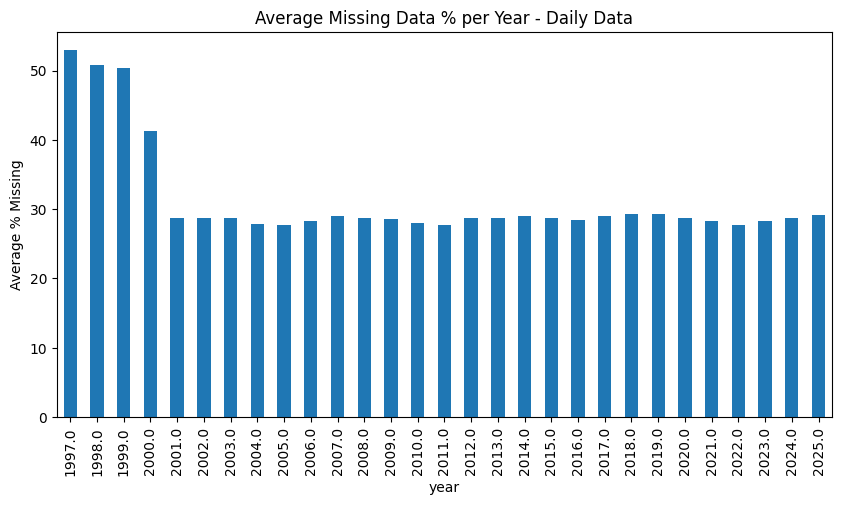

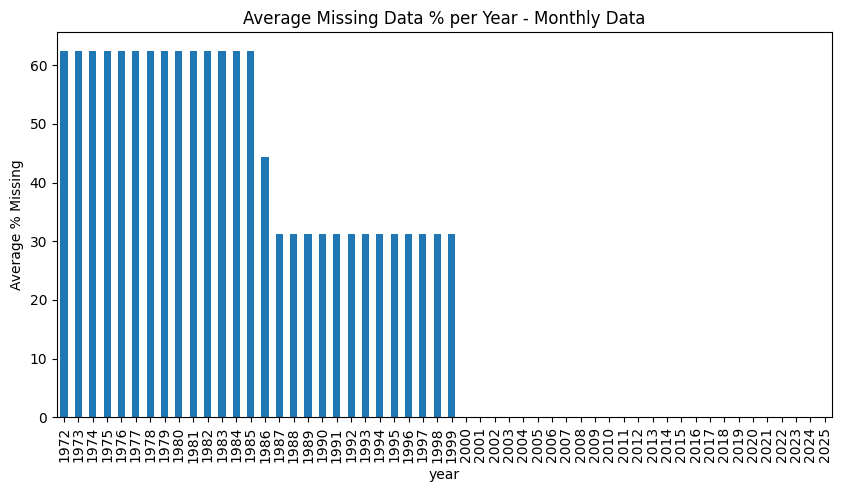

In [8]:
#MISSING DATA OVER TIME ANALYSES

# Voeg 'year' toe aan daily_df en monthly_df
daily_df['year'] = daily_df['years'].dt.year
monthly_df['year'] = monthly_df['years'].dt.year

# Groepeer per jaar en bereken % missing per maturiteit (kolom)
missing_per_year_daily = daily_df.groupby('year').apply(lambda x: x.isna().mean() * 100)
missing_per_year_monthly = monthly_df.groupby('year').apply(lambda x: x.isna().mean() * 100)

# Gemiddelde % missing over alle looptijden per jaar
avg_missing_per_year_daily = missing_per_year_daily.mean(axis=1)
avg_missing_per_year_monthly = missing_per_year_monthly.mean(axis=1)

print("\nAverage missing % per year - Daily:")
print(avg_missing_per_year_daily)

print("\nAverage missing % per year - Monthly:")
print(avg_missing_per_year_monthly)

# Plot
avg_missing_per_year_daily.plot(kind='bar', figsize=(10,5))
plt.ylabel('Average % Missing')
plt.title('Average Missing Data % per Year - Daily Data')
plt.show()

avg_missing_per_year_monthly.plot(kind='bar', figsize=(10,5))
plt.ylabel('Average % Missing')
plt.title('Average Missing Data % per Year - Monthly Data')
plt.show()





